<a href="https://colab.research.google.com/github/bahadirbasaran/pulsarDetection/blob/master/main_withoutOversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment**

In [0]:
import pydot
import numpy as np
import pandas as pd
import seaborn as sb
from graphviz import Source
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from warnings import simplefilter
from xgboost import XGBClassifier
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix
#from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score, classification_report
simplefilter("ignore", UserWarning)
simplefilter("ignore", FutureWarning)
simplefilter("ignore", FitFailedWarning)

**Function&Class Definitions**

In [0]:
def hover(hover_color="#e6e6ff"):
  return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color), ("font-weight", "bold")])

def printDataframe(dataframe, frame_style, sort_by, ascending=False):
  dataframe = dataframe.sort_values(by=sort_by, ascending=ascending)
  display(dataframe.style.set_table_styles(frame_style).hide_index())

def plot_2D_space(X, y, title='Classes'):   
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', 's']
  for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
  plt.title(title, fontsize=16)
  plt.legend(loc='upper right')
  plt.show()

def plot_confusion_matrix(classifier, y_true, y_pred):
  plt.figure(figsize=(10,5))
  sb.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt = "d",linecolor="k",linewidths=3)
  plt.title("Confusion Matrix of {}".format(classifier), fontsize=16)
  plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
  plt.figure(figsize=(10,5))
  plt.title(title, fontsize=16)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training Examples")
  
  if scoring == None:
    plt.ylabel("Accuracy Score")
  else:
    plt.ylabel(scoring + " Score")

  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
  plt.legend(loc="best")
  plt.show()

def plot_feature_importances(classifier, data):
  plt.figure(figsize=(10,5))
  featureImportances = pd.Series(classifier.feature_importances_, index=data.columns[:-1]).sort_values(ascending=False)
  sb.barplot(x=featureImportances, y=featureImportances.index)
  plt.title('Feature Importances', fontsize=16)
  plt.xlabel('Score')
  plt.show()

def plot_decision_tree(classifier, featureNames, rotate=False):
  %matplotlib inline
  dot_data = export_graphviz(classifier, out_file=None, rotate=rotate, feature_names=featureNames, filled=True, rounded=True,special_characters=True)
  pdot = pydot.graph_from_dot_data(dot_data)
  # Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
  pdot[0].set_graph_defaults(size = "\"12,10\"")
  graph = Source(pdot[0].to_string())
  display(graph)

def evaluateClassifier(classifier, y_true, y_pred, elapsedTime, df_stats):  
  score_f1 = f1_score(y_true, y_pred)
  score_acc = accuracy_score(y_true,y_pred)
  score_mse = mean_squared_error(y_true, y_pred)

  dataframe_model = pd.DataFrame(columns=['Model on Test Data', 'F1 Score', 'Accuracy', 'MSE'])
  dataframe_model = dataframe_model.append({"Model on Test Data": classifier, "F1 Score": "%.4f" % score_f1, "Accuracy": "%.4f" % score_acc, "MSE": "%.4f" % score_mse}, ignore_index=True)

  print("\n")
  printDataframe(dataframe=dataframe_model, frame_style=frameStyle, sort_by='F1 Score')
  print("\n")

  plot_confusion_matrix(classifier, y_true, y_pred)

  #Predict probabilities for the test data and Keep Probabilities of the positive class only.
  #probabilities = gs.best_estimator_.predict_proba(X_test)[:, 1]
  # score_cohenKappa = cohen_kappa_score(y_true, y_pred)
  # print("\nClassification Report of {}:\n\n{}".format(classifier, classification_report(y_true, y_pred)))
  # plot_roc_curve(classifier, y_true, probabilities)
  # plot_precision_recall_curve(classifier, y_true, y_pred, probabilities)

  if classifier not in df_stats.values:
    df_stats = df_stats.append({"Model": classifier, "F1 Score": "%.4f" % score_f1, "Accuracy": "%.4f" % score_acc, "MSE": "%.4f" % score_mse, "Elapsed Time":elapsedTime}, ignore_index=True)

  return df_stats

def createDataSplits(dataset, list_dataColumns, targetColumn, testSizeRatio, randomState=42, oversample=True, obj_preprocessing=None, printStats=True):   
  X = dataset[dataset.columns[list_dataColumns]]
  y = dataset[dataset.columns[targetColumn]]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSizeRatio, random_state=randomState, stratify=y)
    
  if obj_preprocessing is not None:
    X_train = obj_preprocessing.fit_transform(X_train)
    X_test = obj_preprocessing.transform(X_test)
    #Index of X_train and X_test are changed. We must reset the index of y_train and y_test.Otherwise, index mismatch error.
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)    
  
  #Oversampling to balance the data set        
  if oversample == True:
    sm = SMOTE(sampling_strategy='minority', random_state=randomState)
    X_train, y_train = sm.fit_sample(X_train, y_train)   
    plot_2D_space(X_train, y_train, title='Dataset After Oversampling')

  if printStats == True:
    print("\nX_train: {} Samples".format(len(X_train)))
    print("y_train: {} Samples".format(len(y_train)))
    print("X_test:  {}  Samples".format(len(X_test)))
    print("y_test:  {}  Samples".format(len(y_test)))

  return X_train, X_test, y_train, y_test

# def plot_roc_curve(classifier, y_true, probabilities):
#   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, probabilities)
#   score_roc_auc = roc_auc_score(y_true, probabilities)
#   plt.figure(figsize=(10,5))
#   plt.plot(false_positive_rate, true_positive_rate, color='orange', label=('AUC Score: ', "%.3f" % score_roc_auc))
#   plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#   plt.xlabel('False Positive Rate')
#   plt.ylabel('True Positive Rate')
#   plt.title('ROC Curve of {}'.format(classifier), fontsize=16)
#   plt.legend(loc='best')
#   plt.show()

# def plot_precision_recall_curve(classifier, y_true, y_pred, probabilities):
#   score_avg_precision = "%.3f" % average_precision_score(y_true, y_pred)
#   precisions, recalls, thresholds = precision_recall_curve(y_true, probabilities)
#   plt.figure(figsize=(10,5))
#   plt.plot(recalls, precisions, marker='.', label=classifier)
#   plt.title("{} Average Precision: {}".format(classifier, score_avg_precision), fontsize=16)
#   plt.xlabel('Recall')
#   plt.ylabel('Precision')
#   plt.legend(loc='best')
#   plt.show()

**Data Import**

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/bahadirbasaran/pulsarDetection/master/pulsar_stars.csv')
dataset.info()
print("\n")
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB




,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


**Data Visualization**



Correlation Matrix Heatmap:




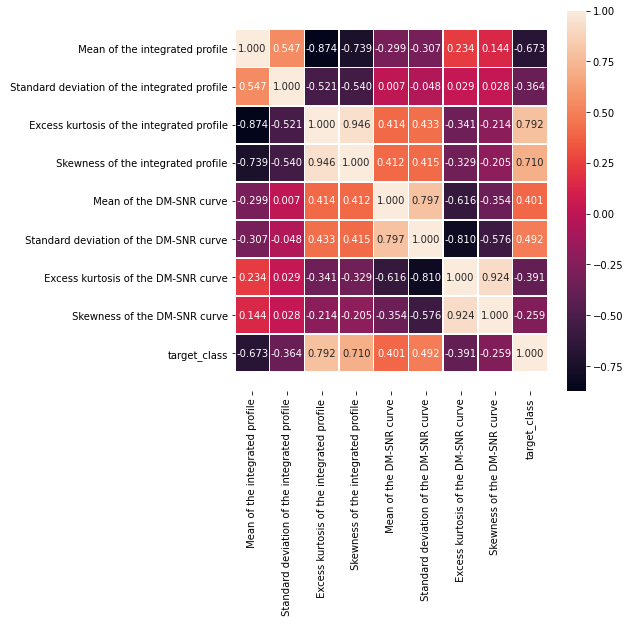



Distribution Plot:



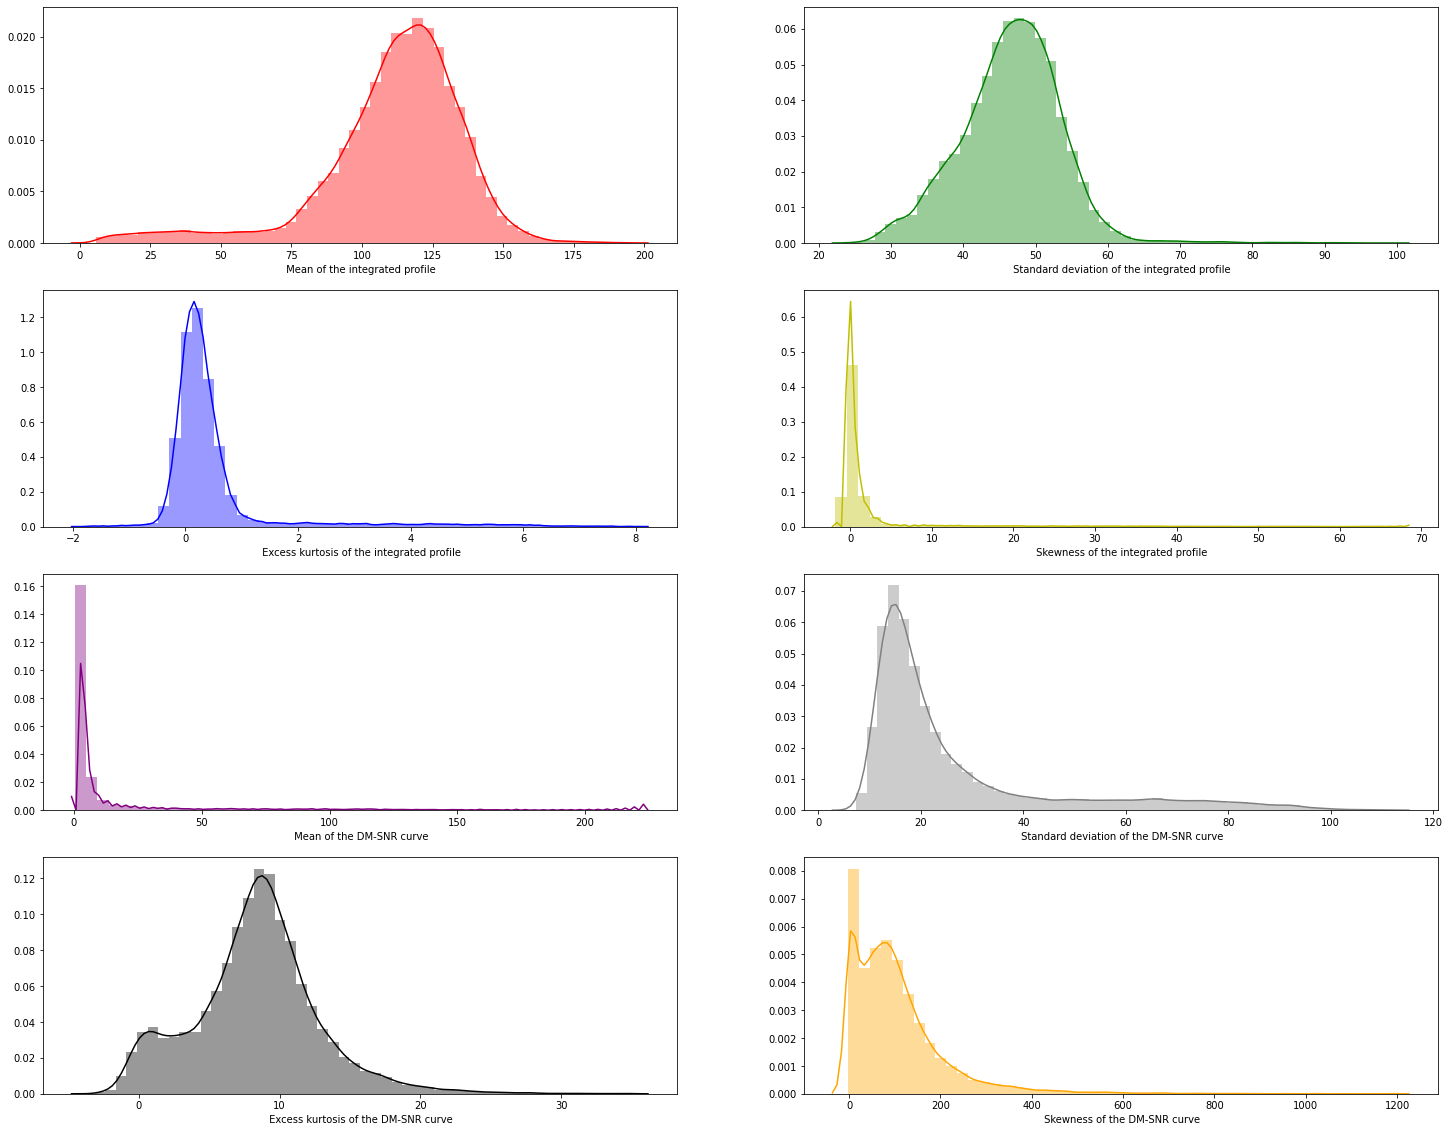



Pair Plot:




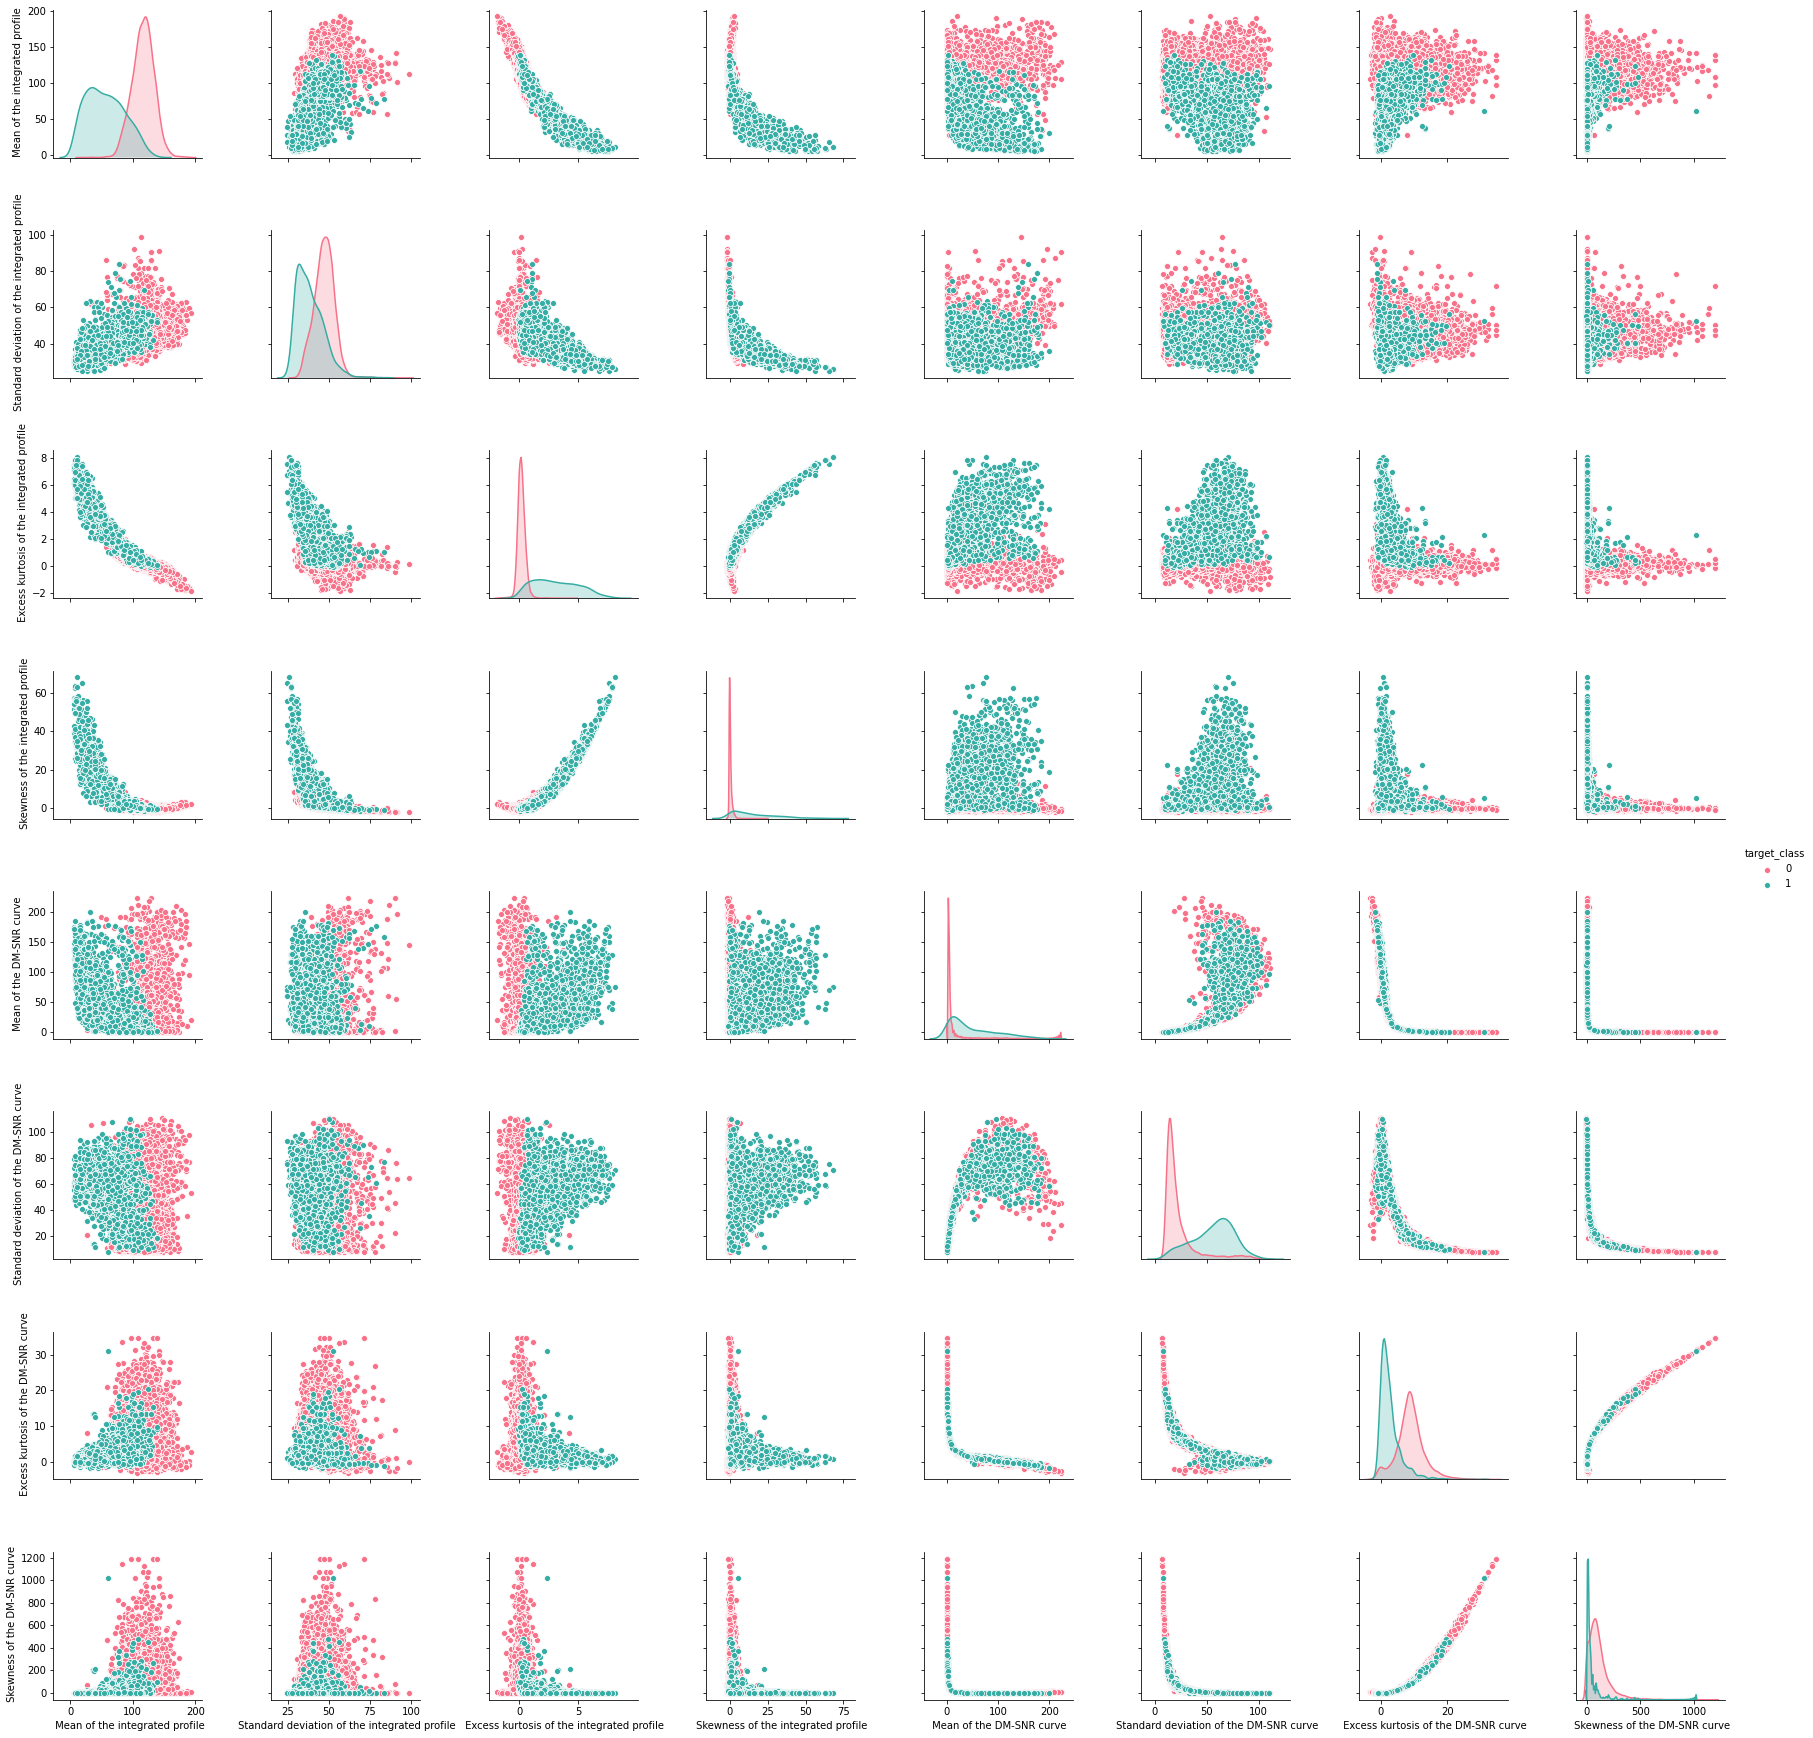



Violin Plot:




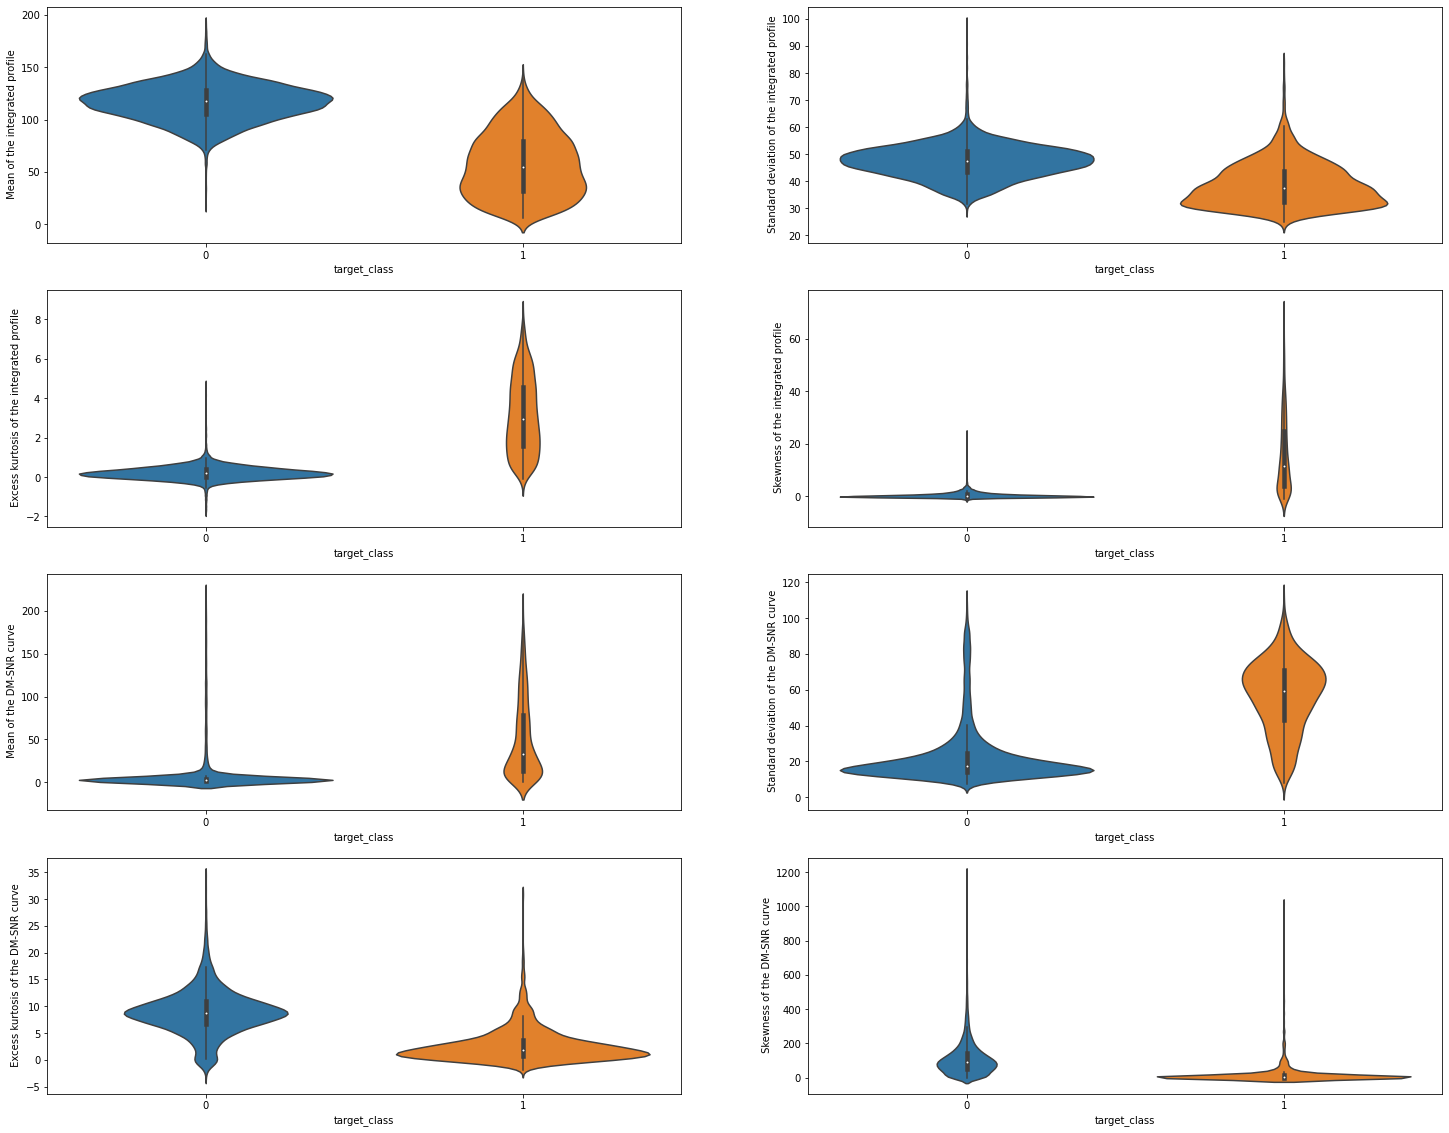

In [0]:
# Correlation Matrix Heatmap
print("\n\nCorrelation Matrix Heatmap:\n\n")
_, ax = plt.subplots(figsize = (7,7))
hm = sb.heatmap(dataset.corr(), annot = True, linewidths=.5, fmt = ".3f", ax=ax)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Dist Plot
print("\n\nDistribution Plot:\n")
plt.figure(figsize=(25,20))
for i, column, color in zip(list(range(0,8)), dataset.columns[:-1], ['r', 'g', 'b', 'y', 'purple', 'grey', 'black', 'orange']):
  plt.subplot(4,2,i+1)
  sb.distplot(dataset[column], color=color)        
plt.show()

# Pair Plot
print("\n\nPair Plot:\n\n")
sb.pairplot(data=dataset, palette="husl", hue="target_class", vars=list(dataset.columns[:-1]), height=3)
plt.show()

# Violin Plot
print("\n\nViolin Plot:\n\n")
plt.figure(figsize=(25,20))
for i in range(8):
  plt.subplot(4,2,i+1)
  sb.violinplot(data=dataset, y=dataset.columns[i], x="target_class")
plt.show()

**Data Splits**

In [4]:
obj_prc = MinMaxScaler()

X_train, X_test, y_train, y_test = createDataSplits(dataset, [0,1,2,3,4,5,6,7], 8, 0.2, obj_preprocessing=obj_prc, oversample=False)


X_train: 14318 Samples
y_train: 14318 Samples
X_test:  3580  Samples
y_test:  3580  Samples


# **Model Preparation&Evaluation**

**Model Preparation**

In [0]:
params_LR  = {"penalty": ['none', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
params_kNN = {"n_neighbors": [3, 5, 9], "metric": ['euclidean', 'manhattan']}
params_RNC = {"radius": [0.15, 0.2, 0.25], "metric": ['minkowski', 'manhattan'], "outlier_label": ['most_frequent']}
params_SVC = {'C': [10, 100], 'gamma': ['scale', 0.0015], 'kernel': ['rbf', 'poly'], 'probability': [True], 'max_iter': [2000]}
params_DT  = {"criterion": ["gini", "entropy"], "max_depth": [1, 3, 5, 7, 9, 11, 13]} 
params_RF  = {"n_estimators": [100, 300], "criterion": ["gini", "entropy"], "max_depth": [1, 3, 5, 7, 9, 11, 13]}
params_AB  = {"n_estimators": [5, 10]}
params_BC  = {"n_estimators": [50, 100]}
params_GB  = {"n_estimators": [100, 300], "max_depth": [1, 3, 5, 7, 9, 11, 13]}
params_XGB = {"n_estimators": [100, 300], "eta": [0.025, 0.05]}
params_ET  = {"n_estimators": [100, 300], "criterion": ["gini", "entropy"], "max_depth": [1, 2, 3, 5, 7, 9, 11, 13]}

list_paramSets = [params_LR, params_kNN, params_RNC, params_SVC, params_DT, params_RF, params_AB, params_BC, params_GB, params_XGB, params_ET]

list_classifiers = [LogisticRegression(), KNeighborsClassifier(), RadiusNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
                    AdaBoostClassifier(), BaggingClassifier(), GradientBoostingClassifier(), XGBClassifier(), ExtraTreesClassifier()]

list_clfNames = ["Logistic Regression", "k-Nearest Neighbors", "Radius Neighbors", "Support Vector Machines", "Decision Tree",
                 "Random Forest", "AdaBoost", "Bagging Classifier", "Gradient Boosting", "XGBoost", "Extra Trees"]

dataframe_stats = pd.DataFrame(columns=['Model', 'F1 Score', 'Accuracy', 'MSE', 'Elapsed Time'])
dataframe_grid  = pd.DataFrame(columns=['Hyperparameter Set', "Mean Cross-val F1 Score"])

frameStyle = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '200px')])]
frameStyle2 = [hover(), dict(selector="th", props=[("font-size", "120%"), ("text-align", "left"), ('min-width', '500px')])]

**Model Evaluation**

Logistic Regression

Mean Cross-validated F1 Score of the Best Estimator: 0.8755



Hyperparameter Set,Mean Cross-val F1 Score
"{'C': 1000, 'penalty': 'l2'}",0.8755
"{'C': 0.01, 'penalty': 'none'}",0.8751
"{'C': 0.1, 'penalty': 'none'}",0.8751
"{'C': 1, 'penalty': 'none'}",0.8751
"{'C': 10, 'penalty': 'none'}",0.8751
"{'C': 100, 'penalty': 'none'}",0.8751
"{'C': 1000, 'penalty': 'none'}",0.8751
"{'C': 100, 'penalty': 'l2'}",0.8728
"{'C': 10, 'penalty': 'l2'}",0.8570
"{'C': 1, 'penalty': 'l2'}",0.8356



Logistic Regression Hyperparameter Set of the Best Estimator:

	Hyperparameter penalty: l2
	Hyperparameter C: 1000




Model on Test Data,F1 Score,Accuracy,MSE
Logistic Regression,0.8827,0.9799,0.0201


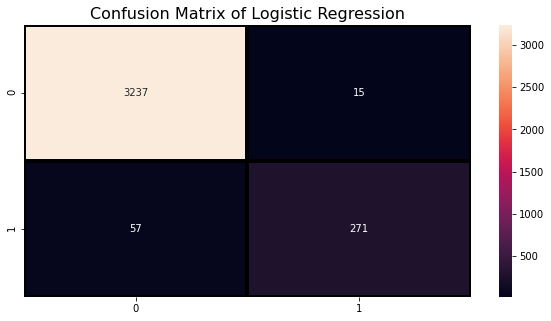

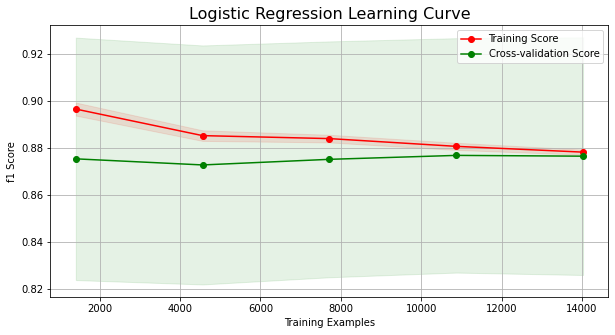


#########################################################################################################################
#########################################################################################################################

k-Nearest Neighbors

Mean Cross-validated F1 Score of the Best Estimator: 0.8729



Hyperparameter Set,Mean Cross-val F1 Score
"{'metric': 'manhattan', 'n_neighbors': 5}",0.8729
"{'metric': 'manhattan', 'n_neighbors': 9}",0.8719
"{'metric': 'euclidean', 'n_neighbors': 5}",0.8712
"{'metric': 'euclidean', 'n_neighbors': 9}",0.8704
"{'metric': 'manhattan', 'n_neighbors': 3}",0.8694
"{'metric': 'euclidean', 'n_neighbors': 3}",0.8671



k-Nearest Neighbors Hyperparameter Set of the Best Estimator:

	Hyperparameter n_neighbors: 5
	Hyperparameter metric: manhattan




Model on Test Data,F1 Score,Accuracy,MSE
k-Nearest Neighbors,0.8822,0.9793,0.0207


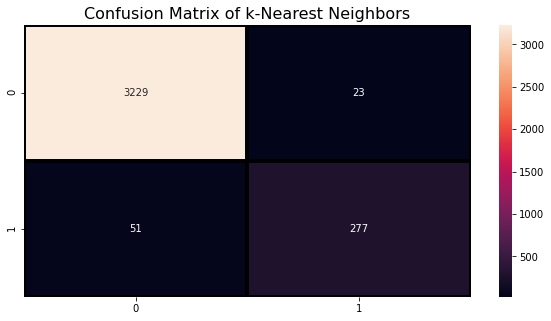

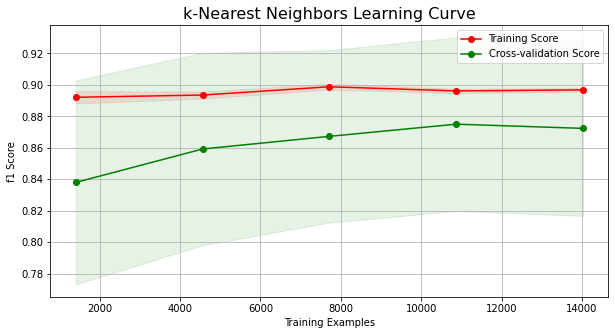


#########################################################################################################################
#########################################################################################################################

Radius Neighbors

Mean Cross-validated F1 Score of the Best Estimator: 0.8407



Hyperparameter Set,Mean Cross-val F1 Score
"{'metric': 'manhattan', 'outlier_label': 'most_frequent', 'radius': 0.25}",0.8407
"{'metric': 'minkowski', 'outlier_label': 'most_frequent', 'radius': 0.15}",0.8388
"{'metric': 'manhattan', 'outlier_label': 'most_frequent', 'radius': 0.2}",0.8387
"{'metric': 'minkowski', 'outlier_label': 'most_frequent', 'radius': 0.2}",0.8322
"{'metric': 'minkowski', 'outlier_label': 'most_frequent', 'radius': 0.25}",0.8140
"{'metric': 'manhattan', 'outlier_label': 'most_frequent', 'radius': 0.15}",0.7920



Radius Neighbors Hyperparameter Set of the Best Estimator:

	Hyperparameter radius: 0.25
	Hyperparameter metric: manhattan
	Hyperparameter outlier_label: most_frequent




Model on Test Data,F1 Score,Accuracy,MSE
Radius Neighbors,0.8586,0.9765,0.0235


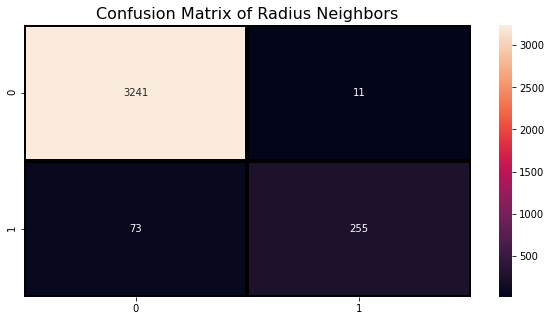

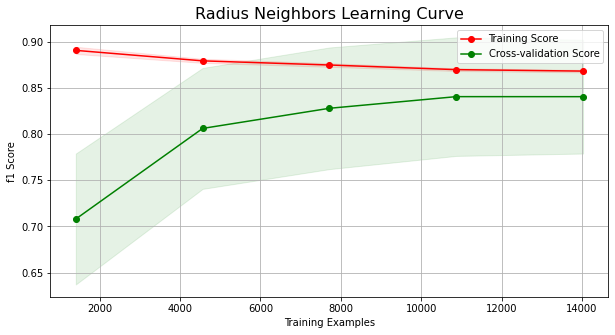


#########################################################################################################################
#########################################################################################################################

Support Vector Machines

Mean Cross-validated F1 Score of the Best Estimator: 0.8823



Hyperparameter Set,Mean Cross-val F1 Score
"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.8823
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.8820
"{'C': 100, 'gamma': 0.0015, 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.8364
"{'C': 10, 'gamma': 0.0015, 'kernel': 'rbf', 'max_iter': 2000, 'probability': True}",0.7665
"{'C': 10, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.5376
"{'C': 100, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.2076
"{'C': 10, 'gamma': 0.0015, 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.0000
"{'C': 100, 'gamma': 0.0015, 'kernel': 'poly', 'max_iter': 2000, 'probability': True}",0.0000



Support Vector Machines Hyperparameter Set of the Best Estimator:

	Hyperparameter C: 100
	Hyperparameter gamma: scale
	Hyperparameter kernel: rbf
	Hyperparameter probability: True
	Hyperparameter max_iter: 2000




Model on Test Data,F1 Score,Accuracy,MSE
Support Vector Machines,0.8801,0.9788,0.0212


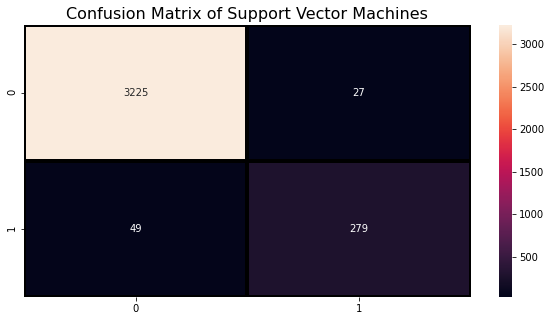

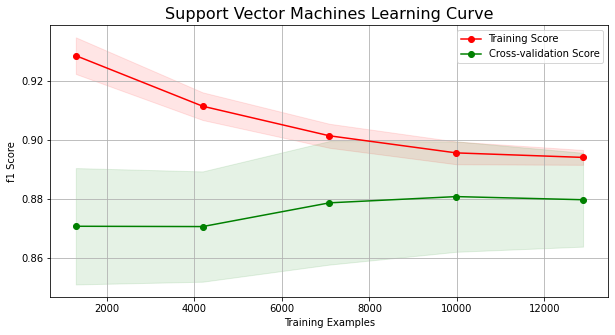


#########################################################################################################################
#########################################################################################################################

Decision Tree

Mean Cross-validated F1 Score of the Best Estimator: 0.8773



Hyperparameter Set,Mean Cross-val F1 Score
"{'criterion': 'entropy', 'max_depth': 5}",0.8773
"{'criterion': 'gini', 'max_depth': 5}",0.8761
"{'criterion': 'entropy', 'max_depth': 7}",0.8747
"{'criterion': 'gini', 'max_depth': 7}",0.8703
"{'criterion': 'gini', 'max_depth': 3}",0.8672
"{'criterion': 'entropy', 'max_depth': 3}",0.8672
"{'criterion': 'gini', 'max_depth': 1}",0.8646
"{'criterion': 'gini', 'max_depth': 9}",0.8611
"{'criterion': 'entropy', 'max_depth': 1}",0.8598
"{'criterion': 'entropy', 'max_depth': 9}",0.8570



Decision Tree Hyperparameter Set of the Best Estimator:

	Hyperparameter criterion: entropy
	Hyperparameter max_depth: 5




Model on Test Data,F1 Score,Accuracy,MSE
Decision Tree,0.8903,0.9807,0.0193


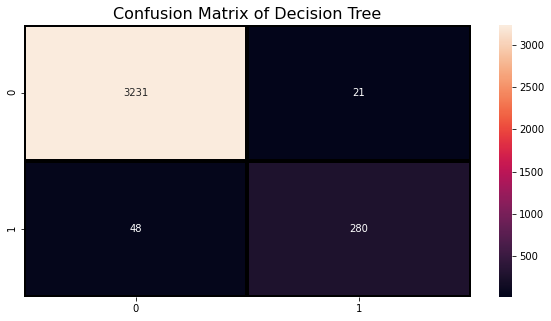

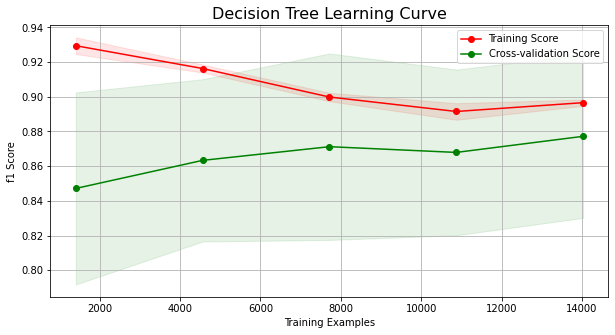

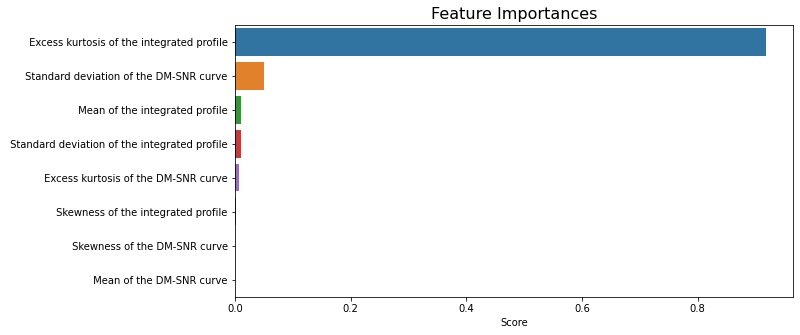

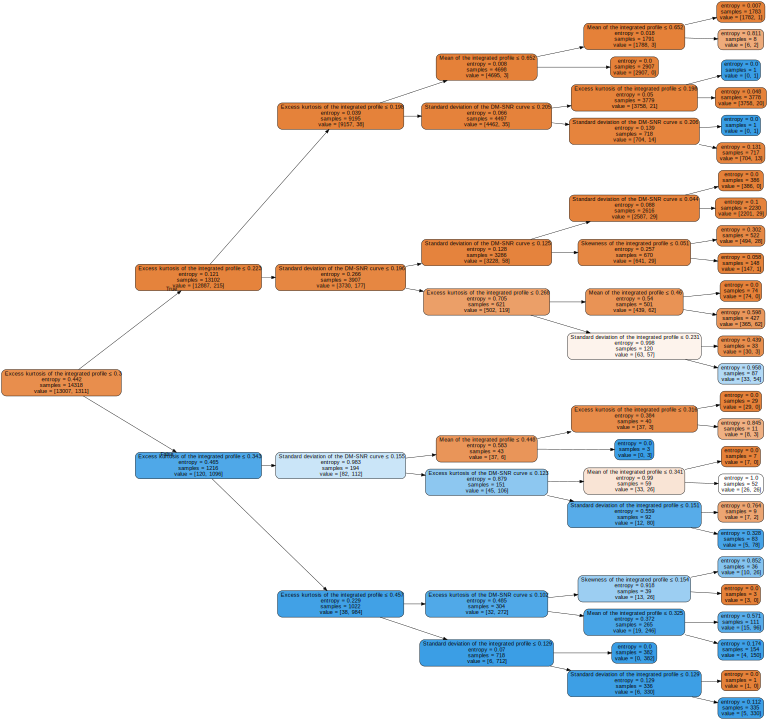


#########################################################################################################################
#########################################################################################################################

Random Forest

Mean Cross-validated F1 Score of the Best Estimator: 0.8862



Hyperparameter Set,Mean Cross-val F1 Score
"{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 300}",0.8862
"{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 100}",0.8852
"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 300}",0.8844
"{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 100}",0.8842
"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}",0.8833
"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 300}",0.8829
"{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}",0.8828
"{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 300}",0.8826
"{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 300}",0.8819
"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 300}",0.8814



Random Forest Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 300
	Hyperparameter criterion: entropy
	Hyperparameter max_depth: 13




Model on Test Data,F1 Score,Accuracy,MSE
Random Forest,0.8934,0.9810,0.0190


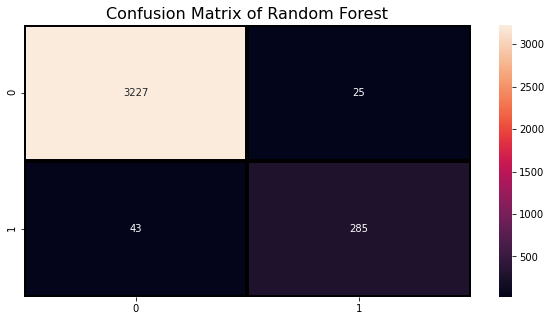

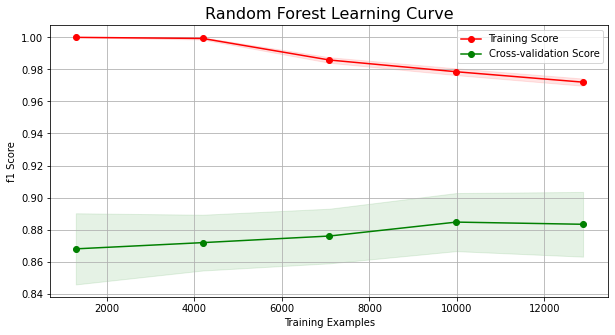

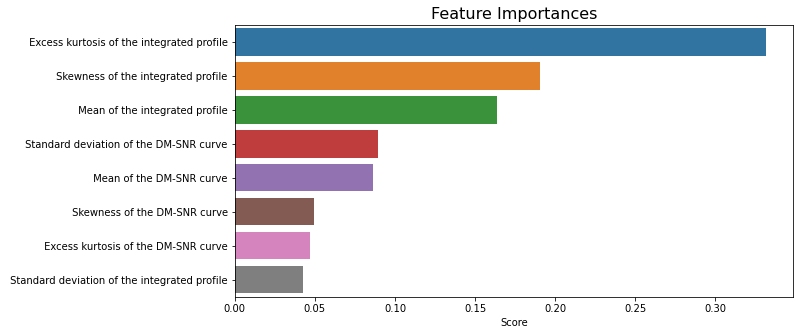


#########################################################################################################################
#########################################################################################################################

AdaBoost

Mean Cross-validated F1 Score of the Best Estimator: 0.8728



Hyperparameter Set,Mean Cross-val F1 Score
"{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', max_depth=5, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), 'n_estimators': 5}",0.8728
"{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', max_depth=5, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), 'n_estimators': 10}",0.8691



AdaBoost Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 5
	Hyperparameter base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')




Model on Test Data,F1 Score,Accuracy,MSE
AdaBoost,0.8885,0.9804,0.0196


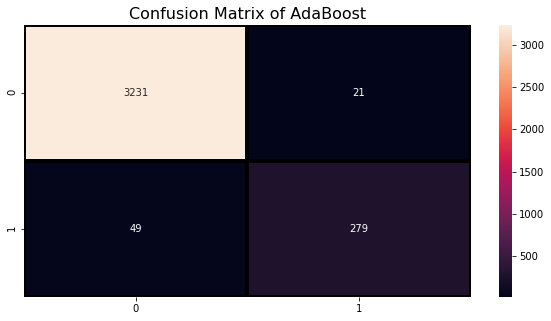

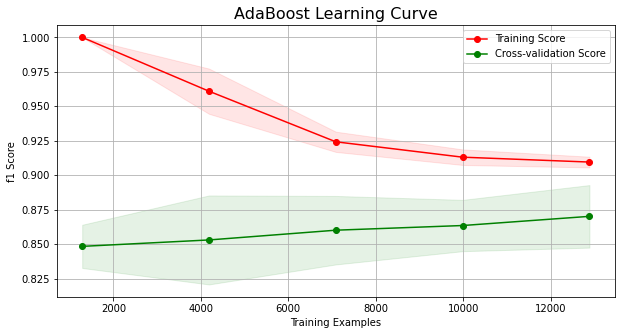

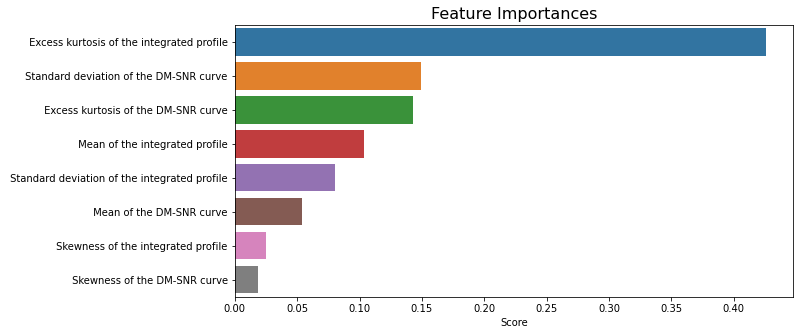


#########################################################################################################################
#########################################################################################################################

Bagging Classifier

Mean Cross-validated F1 Score of the Best Estimator: 0.8825



Hyperparameter Set,Mean Cross-val F1 Score
"{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', max_depth=5, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), 'n_estimators': 100}",0.8825
"{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', max_depth=5, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), 'n_estimators': 50}",0.8812



Bagging Classifier Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 100
	Hyperparameter base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')




Model on Test Data,F1 Score,Accuracy,MSE
Bagging Classifier,0.8945,0.9813,0.0187


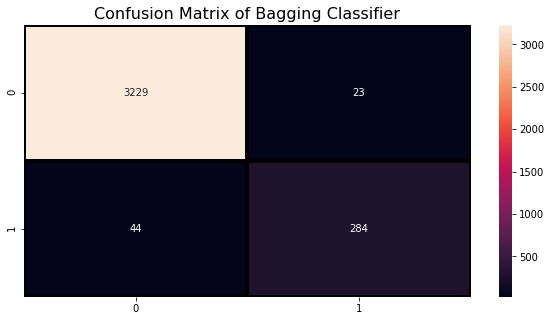

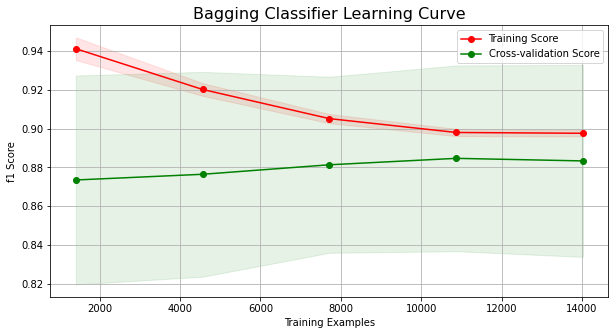


#########################################################################################################################
#########################################################################################################################

Gradient Boosting

Mean Cross-validated F1 Score of the Best Estimator: 0.8833



Hyperparameter Set,Mean Cross-val F1 Score
"{'max_depth': 1, 'n_estimators': 300}",0.8833
"{'max_depth': 9, 'n_estimators': 300}",0.8817
"{'max_depth': 11, 'n_estimators': 100}",0.8799
"{'max_depth': 7, 'n_estimators': 300}",0.8787
"{'max_depth': 9, 'n_estimators': 100}",0.8783
"{'max_depth': 11, 'n_estimators': 300}",0.8778
"{'max_depth': 3, 'n_estimators': 100}",0.8768
"{'max_depth': 13, 'n_estimators': 300}",0.8761
"{'max_depth': 7, 'n_estimators': 100}",0.8750
"{'max_depth': 13, 'n_estimators': 100}",0.8749



Gradient Boosting Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 300
	Hyperparameter max_depth: 1




Model on Test Data,F1 Score,Accuracy,MSE
Gradient Boosting,0.8864,0.9802,0.0198


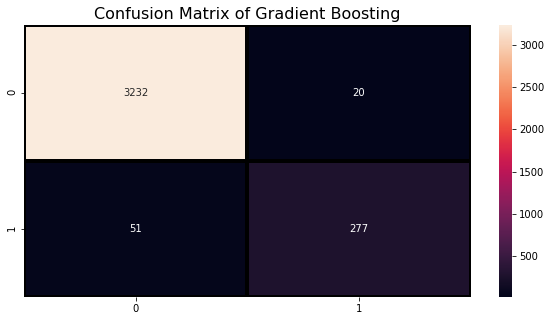

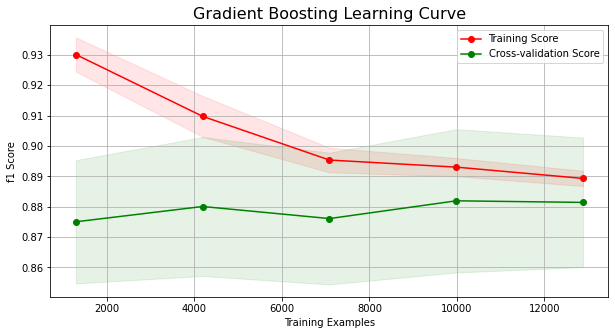

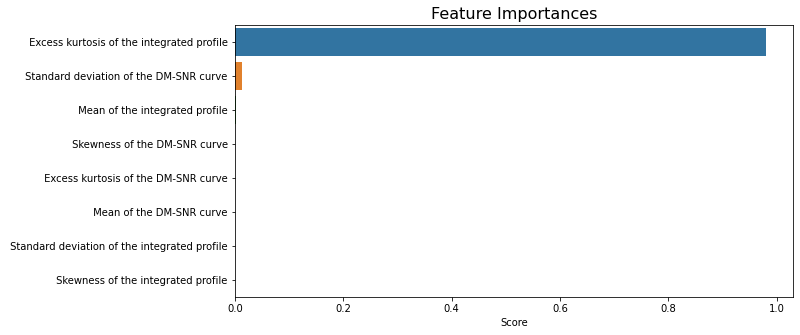


#########################################################################################################################
#########################################################################################################################

XGBoost

Mean Cross-validated F1 Score of the Best Estimator: 0.8866



Hyperparameter Set,Mean Cross-val F1 Score
"{'eta': 0.025, 'n_estimators': 300}",0.8866
"{'eta': 0.05, 'n_estimators': 300}",0.8866
"{'eta': 0.025, 'n_estimators': 100}",0.8848
"{'eta': 0.05, 'n_estimators': 100}",0.8848



XGBoost Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 300
	Hyperparameter eta: 0.025




Model on Test Data,F1 Score,Accuracy,MSE
XGBoost,0.8948,0.9813,0.0187


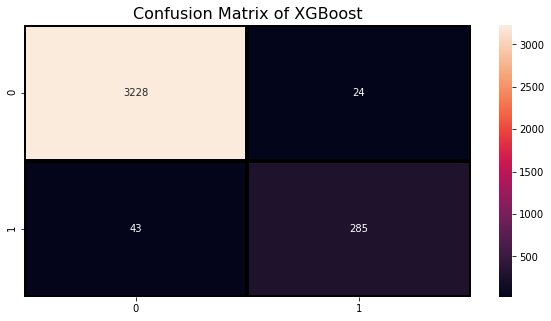

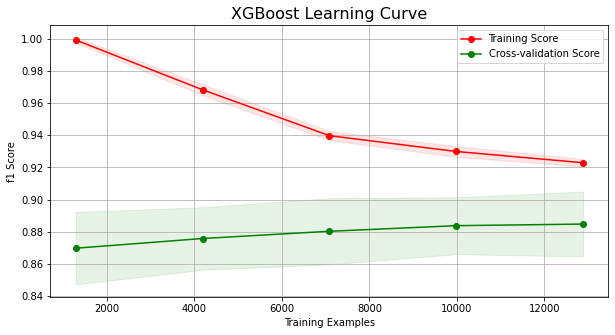

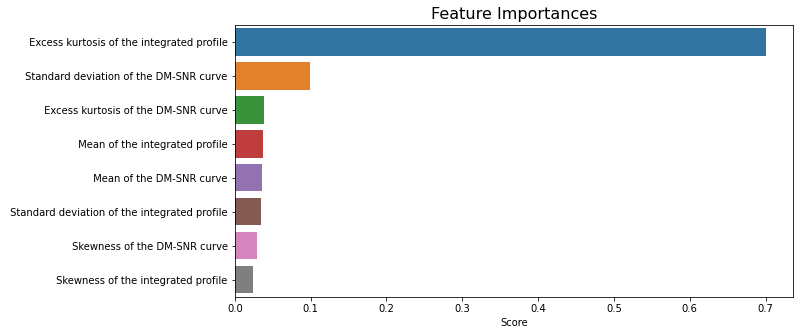


#########################################################################################################################
#########################################################################################################################

Extra Trees

Mean Cross-validated F1 Score of the Best Estimator: 0.8704



Hyperparameter Set,Mean Cross-val F1 Score
"{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 100}",0.8704
"{'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 300}",0.8682
"{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 300}",0.8669
"{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}",0.8669
"{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 100}",0.8652
"{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 300}",0.8648
"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 100}",0.8632
"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 300}",0.8618
"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 300}",0.8514
"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 300}",0.8510



Extra Trees Hyperparameter Set of the Best Estimator:

	Hyperparameter n_estimators: 100
	Hyperparameter criterion: entropy
	Hyperparameter max_depth: 13




Model on Test Data,F1 Score,Accuracy,MSE
Extra Trees,0.8839,0.9799,0.0201


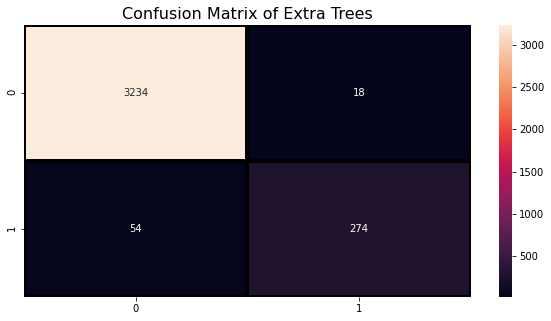

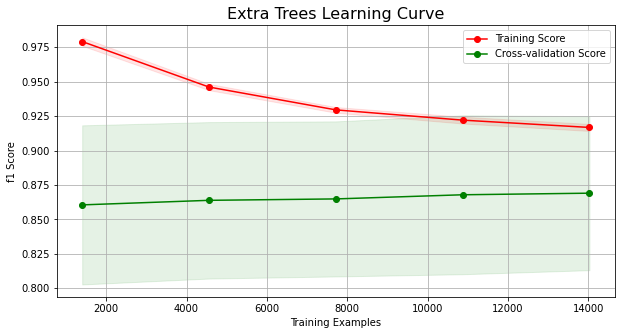

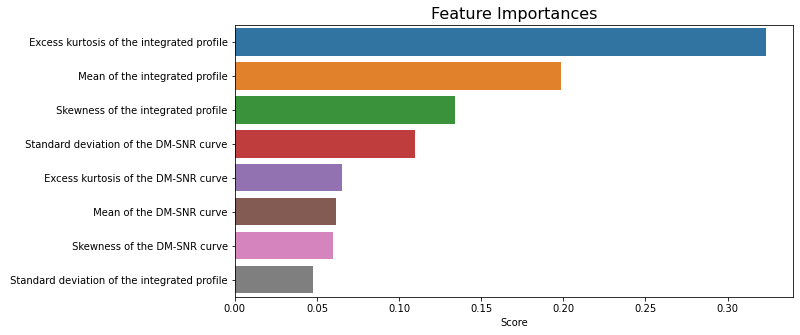


#########################################################################################################################
#########################################################################################################################



Model,F1 Score,Accuracy,MSE,Elapsed Time
XGBoost,0.8948,0.9813,0.0187,2.796504
Bagging Classifier,0.8945,0.9813,0.0187,7.278287
Random Forest,0.8934,0.9810,0.0190,9.891188
Decision Tree,0.8903,0.9807,0.0193,0.108214
AdaBoost,0.8885,0.9804,0.0196,0.593990
Gradient Boosting,0.8864,0.9802,0.0198,4.599641
Extra Trees,0.8839,0.9799,0.0201,0.528881
Logistic Regression,0.8827,0.9799,0.0201,0.161576
k-Nearest Neighbors,0.8822,0.9793,0.0207,0.015326
Support Vector Machines,0.8801,0.9788,0.0212,6.416156


In [6]:
for classifier, paramSet, classifierName in zip(list_classifiers, list_paramSets, list_clfNames):
  
  if classifierName in ["Support Vector Machines", "Gradient Boosting", "Random Forest", "AdaBoost", "XGBoost"]:
    n_folds = 10
  else:
    n_folds = 50
  
  gs = GridSearchCV(
                    estimator = classifier,
                    param_grid = paramSet,
                    cv = n_folds,
                    scoring = 'f1',
                    return_train_score=True              
                   )  
  gs.fit(X_train, y_train)

  print('\033[1m' + '\033[4m' + '\033[36m'  + classifierName + '\033[0m')
  print("\nMean Cross-validated F1 Score of the Best Estimator: {}\n".format("%.4f" % gs.best_score_))

  dataframe_grid = dataframe_grid.iloc[0:0]
  for param, i in zip(gs.cv_results_['params'], range(0, len(gs.cv_results_['params']))):
    dataframe_grid = dataframe_grid.append({"Hyperparameter Set": param, "Mean Cross-val F1 Score": "%.4f" % gs.cv_results_['mean_test_score'][i]}, ignore_index=True)
  printDataframe(dataframe=dataframe_grid, frame_style=frameStyle2, sort_by="Mean Cross-val F1 Score")

  print("\n{} Hyperparameter Set of the Best Estimator:\n".format(classifierName))
  for param in paramSet.keys():
    print("\tHyperparameter {}: {}".format(param, gs.best_estimator_.get_params()[param]))
  
  y_pred = gs.best_estimator_.predict(X_test)

  dataframe_stats = evaluateClassifier(classifierName, y_test, y_pred, gs.refit_time_, dataframe_stats)

  cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  title = classifierName + " Learning Curve"
  plot_learning_curve(gs.best_estimator_, title, X_train, y_train, cv=cv, scoring='f1')

  if classifierName in ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "XGBoost", "Extra Trees"]:
    plot_feature_importances(gs.best_estimator_, dataset)

    #Best estimator that is the result of DecisionTreeClassifier will be used with AdaBoostClassifier and BaggingClassifier
    if classifierName == "Decision Tree":
      params_AB.update({"base_estimator": [gs.best_estimator_]})
      params_BC.update({"base_estimator": [gs.best_estimator_]})

      plot_decision_tree(gs.best_estimator_, dataset.columns[:-1], rotate=True)

  print('\033[1m' + '\033[94m' + "\n#########################################################################################################################")
  print("#########################################################################################################################\n" + '\033[0m')

#Listing the results
printDataframe(dataframe=dataframe_stats, frame_style=frameStyle, sort_by=['F1 Score', 'Accuracy', 'Elapsed Time'], ascending=[False, False, True])